# Importing the necessary libraries

In [118]:
import ee
import geemap
from matplotlib import pyplot as plt
import numpy as np
import PIL

In [119]:
# Initialise Earth Engine
ee.Authenticate()
ee.Initialize(project='directed-sun-356611')

In [120]:
# Duration
date_from = '2016-12-16'
date_to = '2016-12-17'
aoi = geemap.geojson_to_ee('data/warrumbungle_national_park.geojson')

# Rainfall

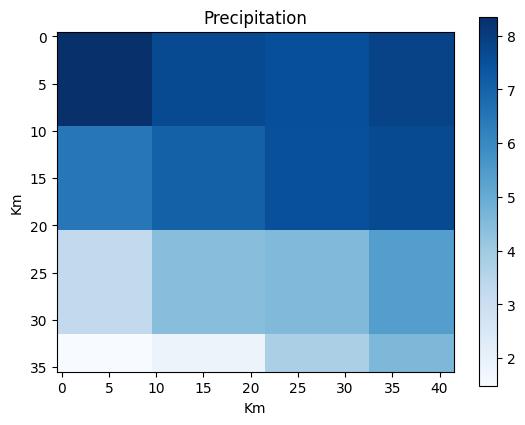

In [121]:
precipitation = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').filterDate(date_from, date_to).select('hourlyPrecipRate').sum().clip(aoi)

precipitationVis = {
  'min': 0.0,
  'max': 30.0,
  'palette': ['1621a2', 'ffffff', '03ffff', '13ff03', 'efff00', 'ffb103', 'ff2300'],
}

Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(precipitation, precipitationVis, 'Precipitation')
Map.to_html('maps/precipitation.html')

# to array
precipitation_array = geemap.ee_to_numpy(precipitation, region=aoi, scale=1000)
plt.title("Precipitation")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(precipitation_array, cmap='Blues')
plt.colorbar()
plt.savefig('images/precipitation.png')
plt.show()

# K Factor


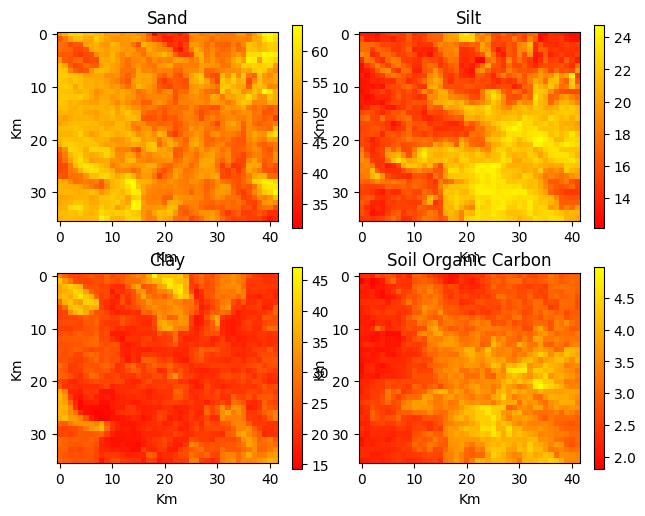

In [122]:
# Components
sand = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SND')).select("SND_000_005_EV").mean()
silt = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SLT')).select("SLT_000_005_EV").mean()
clay = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'CLY')).select("CLY_000_005_EV").mean()
soil_organic_carbon = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SOC')).select("SOC_000_005_EV").mean()

sand_array = geemap.ee_to_numpy(sand, region=aoi, scale=1000)
silt_array = geemap.ee_to_numpy(silt, region=aoi, scale=1000)
clay_array = geemap.ee_to_numpy(clay, region=aoi, scale=1000)
soil_organic_carbon_array = geemap.ee_to_numpy(soil_organic_carbon, region=aoi, scale=1000)

plt.subplot(2, 2, 1)
plt.tight_layout()
plt.title("Sand")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(sand_array, cmap='autumn')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Silt")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(silt_array, cmap='autumn')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Clay")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(clay_array, cmap='autumn')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Soil Organic Carbon")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(soil_organic_carbon_array, cmap='autumn')
plt.colorbar()

plt.savefig('images/soil_components.png')



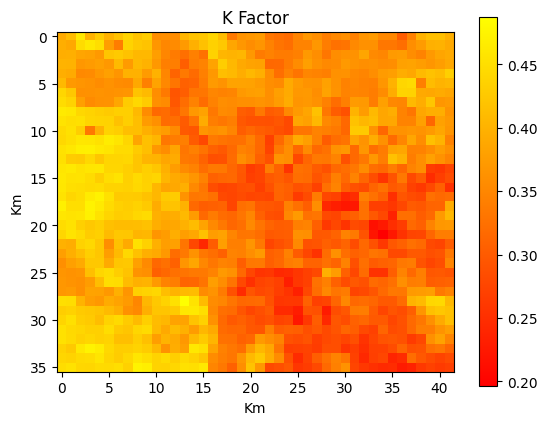

In [123]:
# Get the layers for sand, silt, clay, and organic carbon
sand =ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SND')).select("SND_000_005_EV").mean()
silt = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SLT')).select("SLT_000_005_EV").mean()
clay = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'CLY')).select("CLY_000_005_EV").mean()
soil_organic_carbon = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SOC')).select("SOC_000_005_EV").mean()

# Convert organic carbon to organic matter
organic_matter = soil_organic_carbon.multiply(1.724)

# Calculate the M factor
M = silt.add(sand).multiply(100).subtract(clay)

structure = ee.Number(3)
permeability = ee.Number(3)

K_factor = (ee.Image(2.1).multiply(10**(-4))
            .multiply((ee.Image(12).subtract(organic_matter))
                      .multiply(M.pow(1.14)))
            .add(ee.Image(3.25).multiply(structure.subtract(2)))
            .add(ee.Image(2.5).multiply(permeability.subtract(3)))
           ).divide(100)

K_factor_array = geemap.ee_to_numpy(K_factor, region=aoi, scale=1000)
# Visualization parameters
vis_params = {
    'min': 0,
    'max': 0.05,  # Adjust based on expected K factor range
    'palette': ['blue', 'green', 'yellow', 'orange', 'red']
}

# Set up the map
Map = geemap.Map()
Map.centerObject(ee.Geometry.BBox(112.0, -44.0, 154.0, -9.0), 4)  # Center on Australia
Map.addLayer(K_factor, vis_params, 'Soil Erodibility (K factor)')
Map.to_html('maps/k_factor.html')

plt.title("K Factor")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(K_factor_array, cmap='autumn')
plt.colorbar()
plt.savefig('images/k_factor.png')
plt.show()


# LS Factor

In [124]:
# Get the DEM
dem = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").select('DSM')
proj = dem.first().select(0).projection()
slope = ee.Terrain.slope(dem.mosaic().setDefaultProjection(proj)).clip(aoi)
dem = dem.mosaic().clip(aoi)

dem_array = geemap.ee_to_numpy(dem, region=aoi, scale=30)
slope_array = geemap.ee_to_numpy(slope, region=aoi, scale=30)


elevationVis = {
  'min': 0,
  'max': 5000,
  'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']
}

Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(dem, elevationVis, 'DEM')
Map.addLayer(slope, {'min': 0, 'max': 60}, 'Slope')
Map.to_html('maps/dem.html')

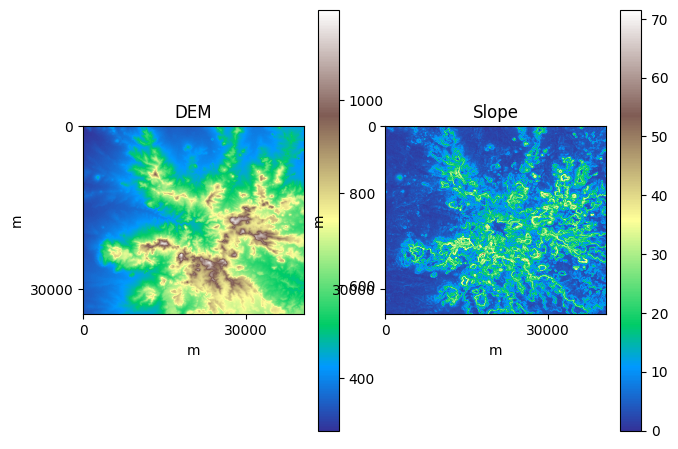

In [125]:
# Plot DEM and Slope
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.title("DEM")
plt.xlabel("m")
plt.ylabel("m")
plt.imshow(dem_array, cmap='terrain')
plt.xticks(np.arange(0, dem_array.shape[1], 1000), np.arange(0, dem_array.shape[1] * 30, 30000))
plt.yticks(np.arange(0, dem_array.shape[0], 1000), np.arange(0, dem_array.shape[0] * 30, 30000))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Slope")
plt.xlabel("m")
plt.ylabel("m")
plt.imshow(slope_array, cmap='terrain')
plt.xticks(np.arange(0, dem_array.shape[1], 1000), np.arange(0, dem_array.shape[1] * 30, 30000))
plt.yticks(np.arange(0, dem_array.shape[0], 1000), np.arange(0, dem_array.shape[0] * 30, 30000))
plt.colorbar()
plt.savefig('images/dem_slope.png')

# C Factor
